In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os
import glob
from tqdm import tqdm
from joblib import Parallel, delayed

from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor

import logging
logger = logging.getLogger("first_model")

# import helpers
import sys
sys.path.append("../../..")
from utils.data import *
from utils.helpers import *
from utils.setup import Config

## Baseline XGBoost Model
Modified to run with the current setup, to see a baseline for any further models.

In [2]:
train = pd.read_csv(Config.data_directory / 'train.csv')
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [3]:
def get_trade_and_book_by_stock_and_time_id(stock_id, time_id=None, dataType = 'train'):
    book_example = pd.read_parquet(f'{Config.data_directory}/book_{dataType}.parquet/stock_id={stock_id}')
    trade_example =  pd.read_parquet(f'{Config.data_directory}/trade_{dataType}.parquet/stock_id={stock_id}')
    if time_id:
        book_example = book_example[book_example['time_id']==time_id]
        trade_example = trade_example[trade_example['time_id']==time_id]
    book_example.loc[:,'stock_id'] = stock_id
    trade_example.loc[:,'stock_id'] = stock_id
    return book_example, trade_example

In [4]:
def calculate_wap1(df):
    a1 = df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']
    b1 = df['bid_size1'] + df['ask_size1']
    a2 = df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']
    b2 = df['bid_size2'] + df['ask_size2']
    
    x = (a1/b1 + a2/b2)/ 2
    
    return x


def calculate_wap2(df):
        
    a1 = df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']
    a2 = df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']
    b = df['bid_size1'] + df['ask_size1'] + df['bid_size2']+ df['ask_size2']
    
    x = (a1 + a2)/ b
    return x

def realized_volatility_per_time_id(file_path, prediction_column_name):

    stock_id = file_path.split('=')[1]

    df_book = pd.read_parquet(file_path)
    df_book['wap1'] = calculate_wap1(df_book)
    df_book['wap2'] = calculate_wap2(df_book)

    df_book['log_return1'] = df_book.groupby(['time_id'])['wap1'].apply(log_return)
    df_book['log_return2'] = df_book.groupby(['time_id'])['wap2'].apply(log_return)
    df_book = df_book[~df_book['log_return1'].isnull()]

    df_rvps =  pd.DataFrame(df_book.groupby(['time_id'])[['log_return1', 'log_return2']].agg(realized_volatility)).reset_index()
    df_rvps[prediction_column_name] = 0.6 * df_rvps['log_return1'] + 0.4 * df_rvps['log_return2']

    df_rvps['row_id'] = df_rvps['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    return df_rvps[['row_id',prediction_column_name]]

In [5]:
def get_agg_info(df):
    agg_df = df.groupby(['stock_id', 'time_id']).agg(mean_sec_in_bucket = ('seconds_in_bucket', 'mean'), 
                                                     mean_price = ('price', 'mean'),
                                                     mean_size = ('size', 'mean'),
                                                     mean_order = ('order_count', 'mean'),
                                                     max_sec_in_bucket = ('seconds_in_bucket', 'max'), 
                                                     max_price = ('price', 'max'),
                                                     max_size = ('size', 'max'),
                                                     max_order = ('order_count', 'max'),
                                                     min_sec_in_bucket = ('seconds_in_bucket', 'min'), 
                                                     min_price = ('price', 'min'),
                                                     median_sec_in_bucket = ('seconds_in_bucket', 'median'), 
                                                     median_price = ('price', 'median'),
                                                     median_size = ('size', 'median'),
                                                     median_order = ('order_count', 'median')
                                                    ).reset_index()
    
    return agg_df

In [9]:
def get_stock_stat(stock_id : int, dataType = 'train'):
    
    book_subset, trade_subset = get_trade_and_book_by_stock_and_time_id(stock_id, dataType=dataType)
    book_subset.sort_values(by=['time_id', 'seconds_in_bucket'])

    ## book data processing
    
    book_subset['bas'] = (book_subset[['ask_price1', 'ask_price2']].min(axis = 1)
                                / book_subset[['bid_price1', 'bid_price2']].max(axis = 1)
                                - 1)                               

    
    book_subset['wap1'] = calculate_wap1(book_subset)
    book_subset['wap2'] = calculate_wap2(book_subset)
    
    book_subset['log_return_bid_price1'] = np.log(book_subset['bid_price1'].pct_change() + 1)
    book_subset['log_return_ask_price1'] = np.log(book_subset['ask_price1'].pct_change() + 1)
    book_subset['log_return_bid_size1'] = np.log(book_subset['bid_size1'].pct_change() + 1)
    book_subset['log_return_ask_size1'] = np.log(book_subset['ask_size1'].pct_change() + 1)
    book_subset['log_ask_1_div_bid_1'] = np.log(book_subset['ask_price1'] / book_subset['bid_price1'])
    book_subset['log_ask_1_div_bid_1_size'] = np.log(book_subset['ask_size1'] / book_subset['bid_size1'])
    

    book_subset['log_return1'] = (book_subset.groupby(by = ['time_id'])['wap1'].
                                  apply(log_return).
                                  reset_index(drop = True).
                                  fillna(0)
                                 )
    book_subset['log_return2'] = (book_subset.groupby(by = ['time_id'])['wap2'].
                                  apply(log_return).
                                  reset_index(drop = True).
                                  fillna(0)
                                 )
    
    stock_stat = pd.merge(
        book_subset.groupby(by = ['time_id'])['log_return1'].agg(realized_volatility).reset_index(),
        book_subset.groupby(by = ['time_id'], as_index = False)['bas'].mean(),
        on = ['time_id'],
        how = 'left'
    )
    
    stock_stat = pd.merge(
        stock_stat,
        book_subset.groupby(by = ['time_id'])['log_return2'].agg(realized_volatility).reset_index(),
        on = ['time_id'],
        how = 'left'
    )
    
    stock_stat = pd.merge(
        stock_stat,
        book_subset.groupby(by = ['time_id'])['log_return_bid_price1'].agg(realized_volatility).reset_index(),
        on = ['time_id'],
        how = 'left'
    )
    stock_stat = pd.merge(
        stock_stat,
        book_subset.groupby(by = ['time_id'])['log_return_ask_price1'].agg(realized_volatility).reset_index(),
        on = ['time_id'],
        how = 'left'
    )
    stock_stat = pd.merge(
        stock_stat,
        book_subset.groupby(by = ['time_id'])['log_return_bid_size1'].agg(realized_volatility).reset_index(),
        on = ['time_id'],
        how = 'left'
    )
    stock_stat = pd.merge(
        stock_stat,
        book_subset.groupby(by = ['time_id'])['log_return_ask_size1'].agg(realized_volatility).reset_index(),
        on = ['time_id'],
        how = 'left'
    )
    
    stock_stat = pd.merge(
        stock_stat,
        book_subset.groupby(by = ['time_id'])['log_ask_1_div_bid_1'].agg(realized_volatility).reset_index(),
        on = ['time_id'],
        how = 'left'
    )
    stock_stat = pd.merge(
        stock_stat,
        book_subset.groupby(by = ['time_id'])['log_ask_1_div_bid_1_size'].agg(realized_volatility).reset_index(),
        on = ['time_id'],
        how = 'left'
    )
    
    
    stock_stat['stock_id'] = stock_id
    
    # Additional features that can be added. Referenced from https://www.kaggle.com/yus002/realized-volatility-prediction-lgbm-train/data
    
    # trade_subset_agg = get_agg_info(trade_subset)
    
    #     stock_stat = pd.merge(
    #         stock_stat,
    #         trade_subset_agg,
    #         on = ['stock_id', 'time_id'],
    #         how = 'left'
    #     )
    
    ## trade data processing 
    
    return stock_stat

def get_data_set(stock_ids : list, dataType = 'train'):

    stock_stat = Parallel(n_jobs=None)(
        delayed(get_stock_stat)(stock_id, dataType) 
        for stock_id in stock_ids
    )
    
    stock_stat_df = pd.concat(stock_stat, ignore_index = True)

    return stock_stat_df

In [10]:
%%time # takes like 20 min, comment out if already ran and saved previously
train_stock_stat_df = get_data_set(train.stock_id.unique(), dataType = 'train')
train_stock_stat_df.head()

Wall time: 19min 17s


,time_id,log_return1,bas,log_return2,log_return_bid_price1,log_return_ask_price1,log_return_bid_size1,log_return_ask_size1,log_ask_1_div_bid_1,log_ask_1_div_bid_1_size,stock_id
0,5,0.004115,0.000852,0.004106,0.002602,0.002476,25.371834,29.772642,0.015251,47.173981,0
1,11,0.001268,0.000394,0.001507,0.003793,0.003685,17.557256,16.155779,0.005999,39.853464,0
2,16,0.002719,0.000725,0.002469,0.001697,0.001792,14.737648,11.275511,0.010191,29.314081,0
3,31,0.002625,0.000861,0.002709,0.002992,0.002740,13.412586,9.774892,0.009908,26.981808,0
4,62,0.001901,0.000397,0.001932,0.002536,0.001926,23.797381,17.759397,0.005543,36.746812,0


In [11]:
train_stock_stat_df.to_pickle("../tmp/baseline_book_data.pickle")  # save to not re-run later

In [12]:
train_stock_stat_df = pd.read_pickle("../tmp/baseline_book_data.pickle")

In [13]:
train_data_set = pd.merge(train, train_stock_stat_df, on = ['stock_id', 'time_id'], how = 'left')

X_display = train_data_set.drop(['stock_id', 'time_id', 'target'], axis = 1)
X = X_display.values
y = train_data_set['target'].values

X.shape, y.shape

((428932, 9), (428932,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=Config.random_state, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((343145, 9), (85787, 9), (343145,), (85787,))

In [15]:
xgb = XGBRegressor(tree_method='hist', random_state = Config.random_state, n_jobs= - 1)

In [16]:
%%time
xgb.fit(X_train, y_train)

Wall time: 1.24 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=420,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)

In [17]:
xgb_preds = xgb.predict(X_test)
R2 = round(r2_score(y_true = y_test, y_pred = xgb_preds), 6)
RMSPE = round(rmspe(y_true = y_test, y_pred = xgb_preds), 6)
print(f'Performance of the naive XGBOOST prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive XGBOOST prediction: R2 score: 0.781913, RMSPE: 0.285728


In [18]:
def plot_feature_importance(df, model):
    feature_importances_df = pd.DataFrame({
        'feature': df.columns,
        'importance_score': model.feature_importances_
    })
    plt.rcParams["figure.figsize"] = [10, 5]
    ax = sns.barplot(x = "feature", y = "importance_score", data = feature_importances_df)
    ax.set(xlabel="Features", ylabel = "Importance Score")
    plt.xticks(rotation=45)
    plt.show()
    return feature_importances_df

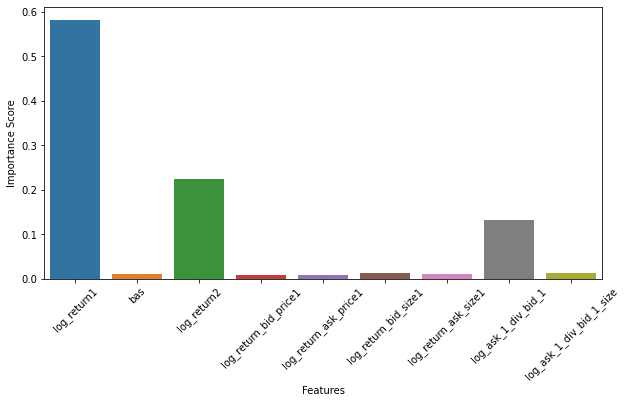

,feature,importance_score
0,log_return1,0.582276
1,bas,0.009393
2,log_return2,0.224372
3,log_return_bid_price1,0.008529
4,log_return_ask_price1,0.008299
5,log_return_bid_size1,0.011557
6,log_return_ask_size1,0.011401
7,log_ask_1_div_bid_1,0.132198
8,log_ask_1_div_bid_1_size,0.011976


In [20]:
import seaborn as sns
plot_feature_importance(X_display, xgb)